In [1]:
import math
import numpy as np
import scipy
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from scipy.stats import linregress
from scipy.fft import fft2, fftfreq
from scipy.io import savemat
from tqdm.auto import tqdm
import re
import numdifftools.nd_algopy as nda
from scipy.special import ellipk, ellipe

In [2]:
# Using natural units
# eps_0 = 1
# mu_0 = 1
# c = 1
# hbar = 1
# k_B = 1
# e = 1
# In SI units,
# c = 2.99792458e8 m/s
# hbar = 6.62607015e-34/(2*pi)
# k_B = 1.380649e-23 J/K
# mu_0 = 1.25663706212e-6 J/m/A^2 (experimental)
# 1 eV = 1.602176634e-19 J
# e = 1.602176634e-19 C
conversions = {
    "m/s": 2.99792458e8,
    "J*s": 6.62607015e-34/(2*np.pi),
    "J/K": 1.380649e-23,
    "J/m/A^2": 1.25663706212e-6,
    "J": 1.602176634e-19,
    "eV": 1,
    "1": 1
}
conversions["s"] = conversions["J*s"] / conversions["J"]
conversions["m"] = conversions["m/s"] * conversions["s"]
conversions["kg"] = conversions["J"] / conversions["m/s"]**2
conversions["g"] = conversions["kg"] / 1000
conversions["A"] = np.sqrt(conversions["J"] / conversions["m"] / conversions["J/m/A^2"])
conversions["C"] = conversions["A"] * conversions["s"]
conversions["V"] = conversions["J"] / conversions["C"]
conversions["N"] = conversions["J"] / conversions["m"]
conversions["W"] = conversions["J"] / conversions["s"]
conversions["T"] = conversions["J"] / conversions["A"] / conversions["m"]**2 
conversions["K"] = conversions["J"] / conversions["J/K"]
conversions["F"] = conversions["C"] / conversions["V"]
conversions["Hz"] = 1/conversions["s"]
conversions["rad"] = 1

In [3]:
prefixes = {
    'G': 1e9,
    'M': 1e-6,
    'k': 1e-3,
    'd': 1e1,
    'c': 1e2,
    'm': 1e3,
    'u': 1e6,
    'μ': 1e6,
    'p': 1e9
}
def get_conversion(unit):
    if unit in conversions:
        return conversions[unit]
    prefix, unit = unit[0], unit[1:]
    if prefix in prefixes and unit in conversions:
        return prefixes[prefix]*conversions[unit]
def conversion_ratio(unit):
    parts = re.split("([*/])", unit)
    conversion = 1
    previous = "*"
    for part in parts:
        result = 1
        if previous in ["*", "/"]:
            if '^' in part:
                left, right = part.split("^")
                result = get_conversion(left)**int(right)
            else:
                result = get_conversion(part)
            if previous == "/":
                result = 1/result
            conversion *= result
        previous = part
    return conversion
def to(unit, val):
    return val * conversion_ratio(unit)
def fr(unit, val):
    return val / conversion_ratio(unit)

In [4]:
def coil(B0, a, pos):
    r = np.linalg.norm(pos[1:2])
    x = np.abs(pos[0])
    if r == 0:
        if x == 0:
            return B_0
        return B_0 * a**3 / (x**2 + a**2)**1.5
    alpha = r/a
    beta = x/a
    gamma = x/r
    Q = (1 + alpha)**2 + beta**2
    k = np.sqrt(4 * alpha / Q)
    K = ellipk(k**2)
    E = ellipe(k**2)
    Bx = np.linalg.norm(B_0) / (np.pi * np.sqrt(Q)) * (E * (1 - alpha**2 - beta**2)/(Q - 4*alpha) + K)
    Br = np.linalg.norm(B_0) * gamma / (np.pi * np.sqrt(Q)) * (E * (1 + alpha**2 + beta**2)/(Q - 4*alpha) - K)
    return Bx * np.array([1, 0, 0]) + Br * np.array([0, pos[1], pos[2]])/r
def G(a, b, theta):
    cs = np.cos(theta)
    sn = np.sin(theta)
    g = 1 - a * cs
    top = 4*g**2 * ((1+a**2) * (1+cs**2) - 4*a*cs) - (1 - a**2 + 3 * b**2) * b**2 * sn**4
    bottom = 4 * (g**2 - (b**2) * (sn**2))**3.5
    F = top/bottom
    return 3/4 * (1 - (a**2 + b**2))**2 * F
def gamma_p(p, axis=0):
    return np.sqrt(1 + (np.linalg.norm(p[1:], axis=axis)/m/c)**2)
def gamma_u(u, axis=0):
    return gamma_p(u*m, axis=axis)
def field_tensor(x):
    Ex, Ey, Ez = E_x(x)
    Bx, By, Bz = B_x(x)
    return np.array([
        [0, Ex, Ey, Ez],
        [Ex, 0, Bz, -By],
        [Ey, -Bz, 0, Bx],
        [Ez, By, -Bx, 0]
    ])
def partial_scalar(original, function, x, direction, delta=1e-10):
    return (function(x + direction*delta) - original)/delta
def partial_vector(f, x, original=None):
    if original is None:
        original = f(x)
    return np.apply_along_axis(lambda direction: partial_scalar(original, f, x, direction), 0, np.eye(4))
def contract(X, eta = np.diag([1, -1, -1, -1])):
    return np.einsum("ab,b->a", eta, X)
def contract_twice(X, eta = np.diag([1, -1, -1, -1])):
    return np.einsum("ac,bd,cd->ab", eta, eta, X)
def fun(t, y):
    u, x = np.split(y, 2)
    F = field_tensor(x)
    pF = partial_vector(field_tensor, x, F)
    wdot = e/m * (np.einsum("l,luv,v", u, pF, u) + e/m * np.einsum("uv,vl,l", F, F, u))
    dudtau = e/m * np.einsum("uv,v->u", F, u)
    dudtau += 2/3 * e**2 / m * np.einsum("uv,v->u", np.einsum("u,v->uv", wdot, contract(u)) - np.einsum("u,v->uv", u, contract(wdot)), u)
    dxdtau = u
    dydtau = np.concatenate([dudtau, dxdtau])
    return dydtau
def str_fixed(arr):
    return np.array2string(arr, precision=3, sign="-", suppress_small=True, separator=",", floatmode="maxprec_equal").replace(" ", "")
def run(fun, t, y, progress, time_unit="us"):
    u, x = np.split(y, 2)
    progress.set_postfix(p=f'{str_fixed(to("MeV", u*m))}MeV', x=f'{str_fixed(to("mm", x))}mm', refresh=False)
    progress.n = to(time_unit, t)
    progress.update(0)
    return fun(t, y)

In [5]:
num_points = 10000
e = fr("C", 1.602176634e-19)
q = e
c = 1
m = fr("eV", 5.1099906e5)
E_0 = fr("V/m", np.array([0, 0, 0]))
E_x = lambda x: E_0
B_0 = fr("T", np.array([10, 0, 0]))
B_x = lambda x: B_0
tau_span = (0, fr("us", 0.05))
p0 = fr("MeV", np.array([0, 100, 100, 0])/np.sqrt(2))
p0[0] = gamma_p(p0)*m
u0 = p0/m
x0 = fr("m", np.array([0, 0, 0, 0]))
rtol = 1e-10
u_atol = fr("keV", 1)/m
x_atol = fr("cm", 1)
max_step = tau_span[1]/num_points*10
atol = np.array([u_atol, u_atol, u_atol, u_atol, x_atol, x_atol, x_atol, x_atol])
tau_eval = np.linspace(*tau_span, num_points) # 10000 points inside t_span

In [6]:
y0 = np.concatenate([u0, x0])
method = "RK45"
time_unit = "ps"
bar_format = "{l_bar}{bar}| {n_fmt:.5}/{total_fmt:.5}{unit} [{elapsed}<{remaining}, {rate_fmt}{postfix}]"
bar_start = to(time_unit, tau_span[0])
bar_end = to(time_unit, tau_span[1])
bar_update_interval = 0.1
with tqdm(
        total=bar_end,
        position=bar_start, 
        leave=True, 
        mininterval=bar_update_interval, 
        maxinterval=bar_update_interval,
        bar_format=bar_format,
        unit=time_unit
    ) as progress:
    solution = solve_ivp(
        lambda tau, y: run(fun, tau, y, progress, time_unit),
        tau_span,
        y0,
        method=method,
        t_eval=tau_eval,
        dense_output=True,
        max_step=max_step,
        rtol=rtol,
        atol=atol
    )

  0%|          | 0/50.0ps [00:00<?, ?ps/s]

In [8]:
solution

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 982844
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000002806EDF65B0>
   status: 0
  success: True
        t: array([0.00000000e+00, 7.59709695e+03, 1.51941939e+04, ...,
       7.59481782e+07, 7.59557753e+07, 7.59633724e+07])
 t_events: None
        y: array([[ 1.95697631e+02,  1.95693067e+02,  1.95688504e+02, ...,
         1.74977756e+02,  1.74977171e+02,  1.74976586e+02],
       [ 1.38377315e+02,  1.38374088e+02,  1.38370862e+02, ...,
         1.23726343e+02,  1.23725929e+02,  1.23725515e+02],
       [ 1.38377315e+02, -1.11826351e+02,  4.23795491e+01, ...,
        -4.25026287e+01,  5.24120672e+01, -4.22198415e+01],
       ...,
       [ 0.00000000e+00,  1.05125362e+06,  2.10248273e+06, ...,
         9.78183061e+09,  9.78277057e+09,  9.78371053e+09],
       [ 0.00000000e+00,  7.03913131e+04, -1.13767920e+05, ...,
        -2.65013563e+04, -1.97824851e

In [9]:
y = solution.y
u, x = np.split(y, 2)

In [10]:
t = x[0]/c
p = u[1:]*m
r = x[1:]

In [11]:
v = u[1:] / gamma_p(u*m, axis=0)
r_corr = r - np.tile(np.mean(r, axis=1), (r.shape[1],1)).T
v_corr = v - np.tile(np.mean(v, axis=1), (v.shape[1],1)).T
omega = np.cross(r_corr, v_corr, axis=0)/np.linalg.norm(r_corr[1:], axis=0)**2
beta_perp = np.linalg.norm(v_corr[1:], axis=0)/c
beta = np.linalg.norm(v_corr, axis=0)/c
power = 2*(e*omega[0])**2/(3*c)*(beta_perp**2)/(1 - beta**2)
frequency = 2 * np.pi * np.abs(omega[0])
period = 1/frequency
B = np.apply_along_axis(B_x, 0, x)
E = np.apply_along_axis(E_x, 0, x)
beta = v/c
bll = (np.sum(beta*B, 0)/np.linalg.norm(B, axis=0))
bperp = np.sqrt(np.linalg.norm(beta, axis=0)**2 - bll**2)

In [7]:
def plot(ax, u, label_u, unit_u, c=None, label_c=None, unit_c=None):
    u = to(unit_u, u)
    if c is not None:
        if unit_c is not None:
            c = to(unit_c, c)
        if u.ndim > 1 and u.shape[0] > 1:
            sc = ax.scatter(*u, c=c, cmap="hot", marker=".", s=1)
            ax.set_xlabel(f"{label_u}_x ({unit_u})")
            ax.set_ylabel(f"{label_u}_y ({unit_u})")
            if u.shape[0] > 2:
                ax.set_zlabel(f"{label_u}_z ({unit_u})")
                plt.colorbar(sc, ax=ax, location="bottom", shrink=0.5, pad=0.01, label=f"{label_c} ({unit_c})")
            else:
                plt.colorbar(sc, ax=ax, location="bottom", pad=0.1, label=f"{label_c} ({unit_c})")
        else:
            if u.ndim > 1:
                u = u[0]
            ax.scatter(c, u, marker=".", s=1)
            ax.set_xlabel(f"{label_c} ({unit_c})")
            ax.set_ylabel(f"{label_u} ({unit_u})")
    else:
        if u.ndim > 1 and u.shape[0] > 1:
            sc = ax.scatter(*u, marker=".", s=1)
            ax.set_xlabel(f"{label_u}_x ({unit_u})")
            ax.set_ylabel(f"{label_u}_y ({unit_u})")
            if u.shape[0] > 2:
                ax.set_zlabel(f"{label_u}_z ({unit_u})")
    return ax
def linear_fit(x, y, x_label="x", y_label="y", units=""):
    fit, cov = np.polyfit(x, y, 1, cov=True)
    uncertainty = np.sqrt(np.diag(cov))
    f = np.poly1d(fit)
    print(f"{y_label} = {fit[0]:.3}±{uncertainty[0]:.3} {x_label} + {fit[1]:.3}±{uncertainty[1]:.3} {units}")
    return f

In [12]:
standard_figsize = (8, 6)
square_figsize = (7.5, 10)
double_square_figsize = (15, 10)
large_standard_figsize = (16, 12)

<Axes3DSubplot:xlabel='v_x (m/s)', ylabel='v_y (m/s)'>

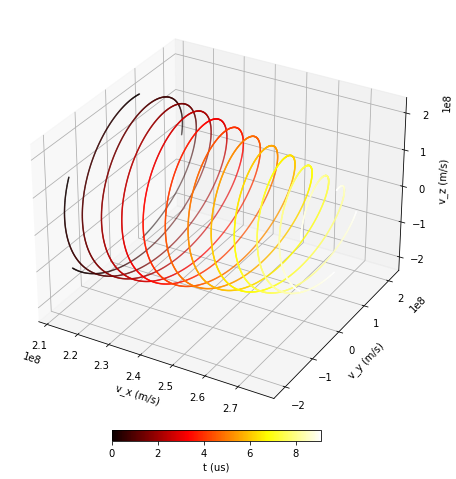

In [13]:
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw=dict(projection="3d"))
plot(ax, v, "v", "m/s", t, "t", "us")

<Axes3DSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

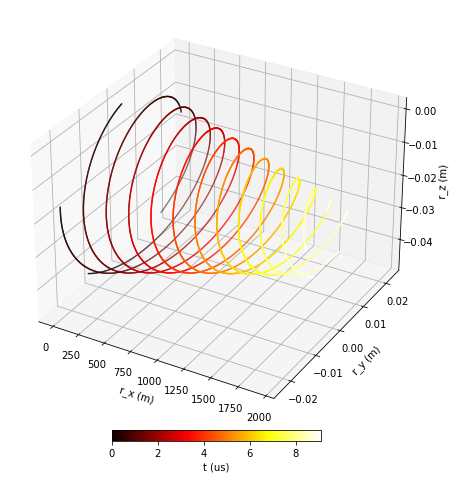

In [14]:
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw=dict(projection="3d"))
plot(ax, r, "r", "m", t, "t", "us")

<AxesSubplot:xlabel='t (us)', ylabel='E (MeV)'>

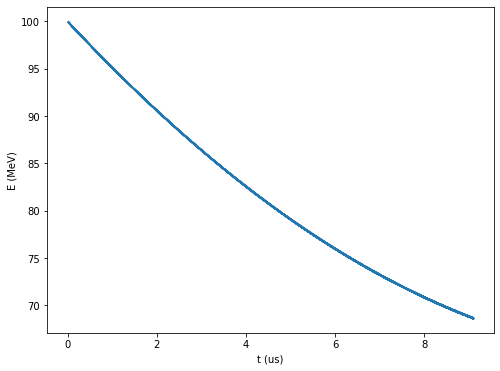

In [15]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), np.sqrt(np.linalg.norm(p, axis=0)**2 + (m*c**2)**2), "E", "MeV", t, "t", "us")

<AxesSubplot:xlabel='t (us)', ylabel='r (m)'>

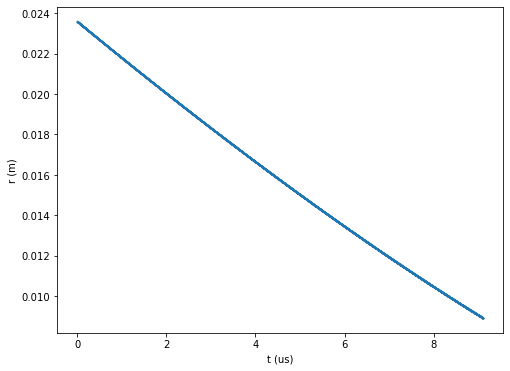

In [16]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), np.linalg.norm(r_corr[1:], axis=0), "r", "m", t, "t", "us")

<AxesSubplot:xlabel='t (us)', ylabel='v (m/s)'>

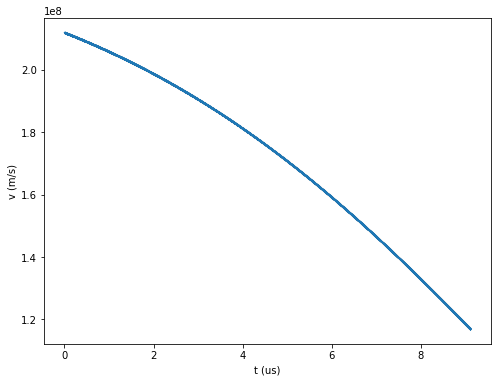

In [17]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), np.linalg.norm(v_corr[1:], axis=0), "v", "m/s", t, "t", "us")

<AxesSubplot:xlabel='t (us)', ylabel='f (Hz)'>

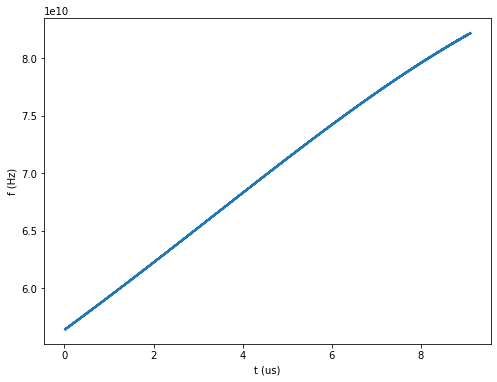

In [18]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), frequency, "f", "Hz", t, "t", "us")
# plt.yscale("log")

<AxesSubplot:xlabel='t (us)', ylabel='T (us)'>

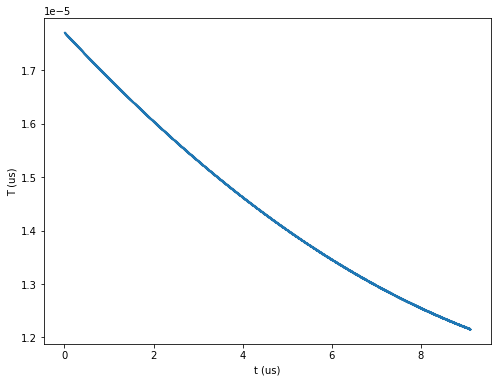

In [19]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), period, "T", "us", t, "t", "us")
# plt.yscale("log")

<AxesSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

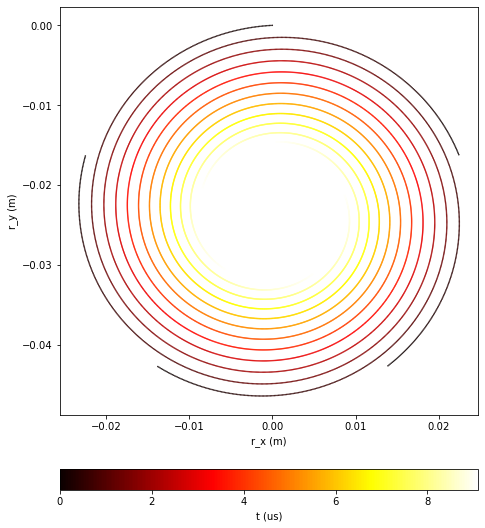

In [20]:
plt.figure(figsize=square_figsize)
plot(plt.axes(), r[1:], "r", "m", t, "t", "us")

<AxesSubplot:xlabel='v_x (m/s)', ylabel='v_y (m/s)'>

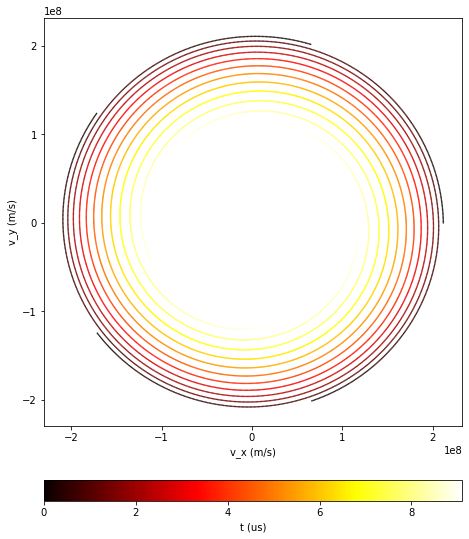

In [21]:
plt.figure(figsize=square_figsize)
plot(plt.axes(), v[1:], "v", "m/s", t, "t", "us")

<AxesSubplot:xlabel='t (us)', ylabel='P (W)'>

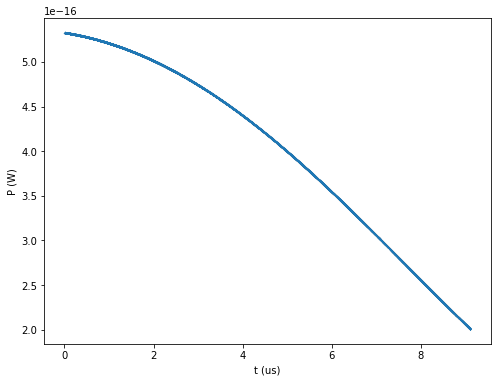

In [22]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), power, "P", "W", t, "t", "us")
# plt.yscale("log")

In [23]:
every_n = 200

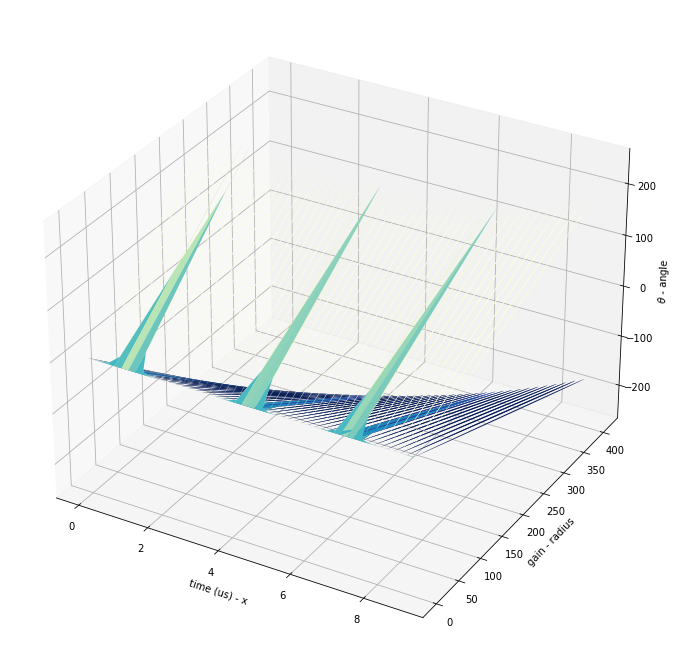

In [24]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
t_plot = t[::every_n]
p = np.linspace(0, 2*np.pi, 10000)
T, P = np.meshgrid(t[::every_n], p)
R = G(bll[::every_n], bperp[::every_n], P)
X, Y = R*np.cos(P), R*np.sin(P)
Z = T
ax.plot_surface(to("us",Z), X, Y, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("time (us) - x")
ax.set_ylabel("gain - radius")
ax.set_zlabel("$\\theta$ - angle")
plt.show()

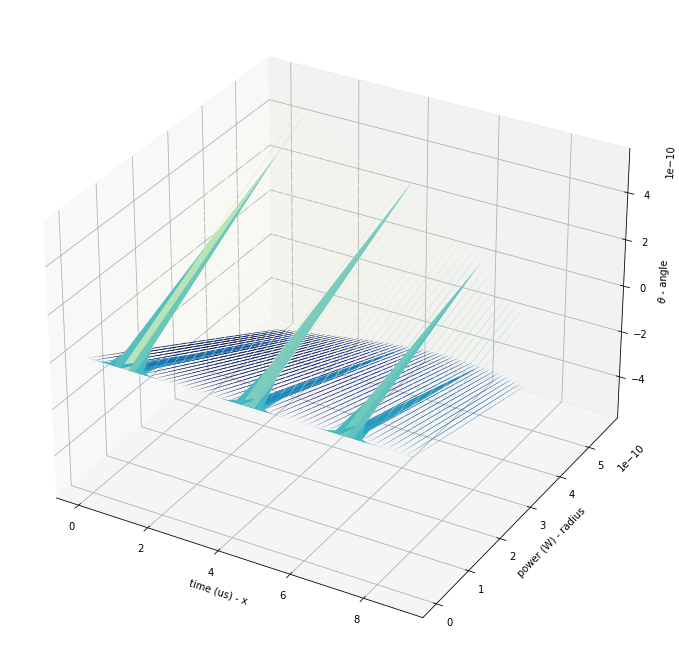

In [25]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
p = np.linspace(0, 2*np.pi, 10000)
T, P = np.meshgrid(t[1::every_n], p)
R = G(bll[1::every_n], bperp[1::every_n], P)*power[1::every_n]
X, Y = R*np.cos(P), R*np.sin(P)
Z = T
ax.plot_surface(to("us",Z), X, Y, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("time (us) - x")
ax.set_ylabel("power (W) - radius")
ax.set_zlabel("$\\theta$ - angle")
plt.show()

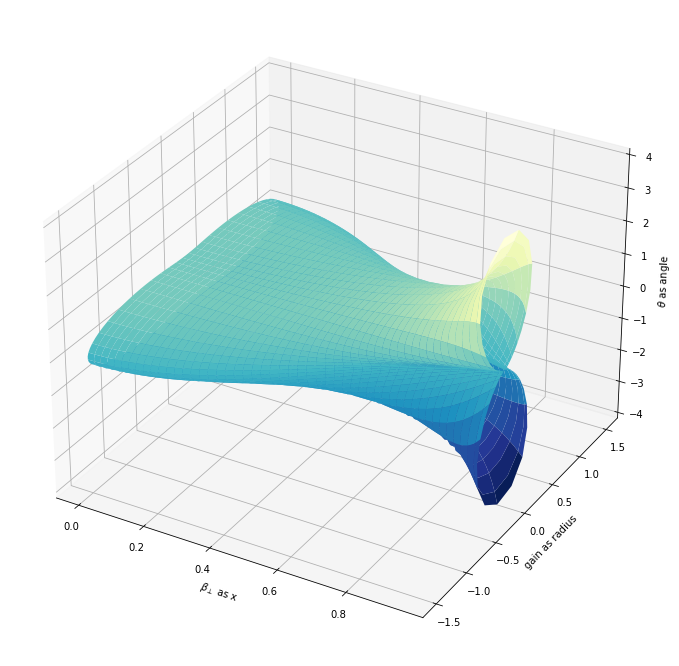

In [33]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
b = np.linspace(0, 0.95, 100)
p = np.linspace(0, 2*np.pi, 100)
B, P = np.meshgrid(b, p)
R = G(0, B, P)
X = B
Y, Z = R*np.cos(P), R*np.sin(P)
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("$\\beta_{\perp}$ as x")
ax.set_ylabel("gain as radius")
ax.set_zlabel("$\\theta$ as angle")
plt.show()

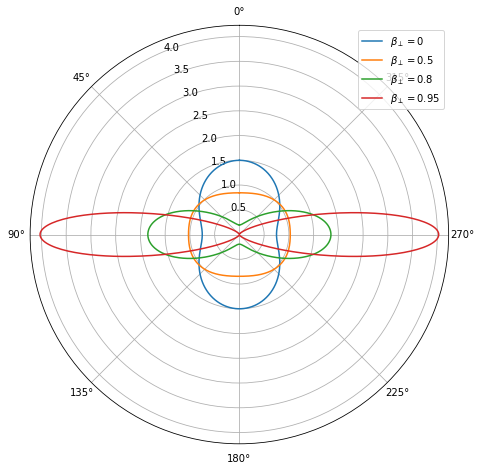

In [34]:
theta = np.linspace(0, 2*np.pi, 1000)
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
for bperp in [0, 0.5, 0.8, 0.95]:
    ax.plot(theta, G(0, bperp, theta), label="$\\beta_{\perp} = " + str(bperp) + "$")
plt.legend()
ax.grid(True)
plt.show()

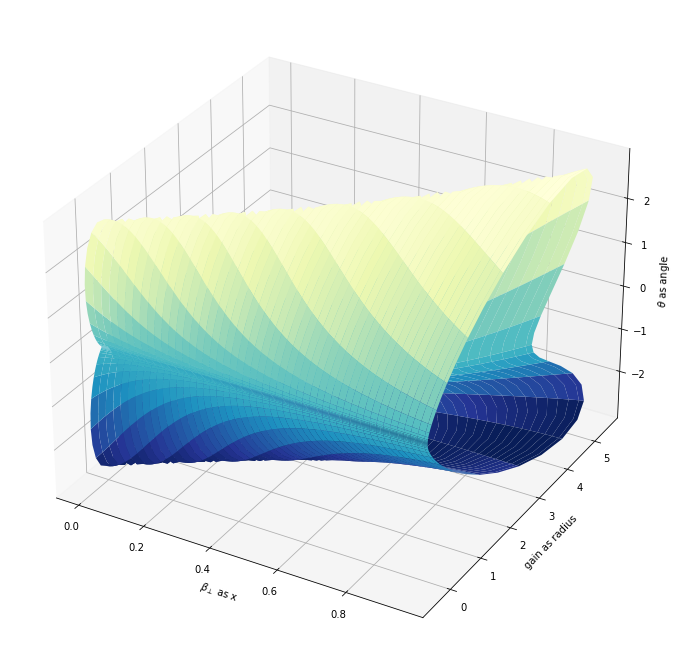

In [35]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
r = np.linspace(0, 1.5, 100)
p = np.linspace(0, 2*np.pi, 100)
ratio, P = np.meshgrid(r, p)
bperp = 0.9/np.sqrt(ratio**2 + 1)
bll = bperp*ratio
R = G(bll, bperp, P)
X = B
Y, Z = R*np.cos(P), R*np.sin(P)
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("$\\beta_{\perp}$ as x")
ax.set_ylabel("gain as radius")
ax.set_zlabel("$\\theta$ as angle")
plt.show()

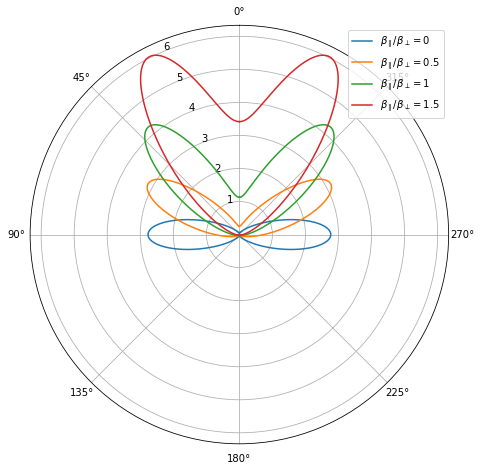

In [36]:
theta = np.linspace(0, 2*np.pi, 1000)
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
for ratio in [0, 0.5, 1, 1.5]:
    bperp = 0.9/np.sqrt(ratio**2 + 1)
    bll = bperp*ratio
    ax.plot(theta, G(bll, bperp, theta), label="$\\beta_{\parallel} / \\beta_{\perp} = " + str(ratio) + "$")
plt.legend()
ax.grid(True)
plt.show()

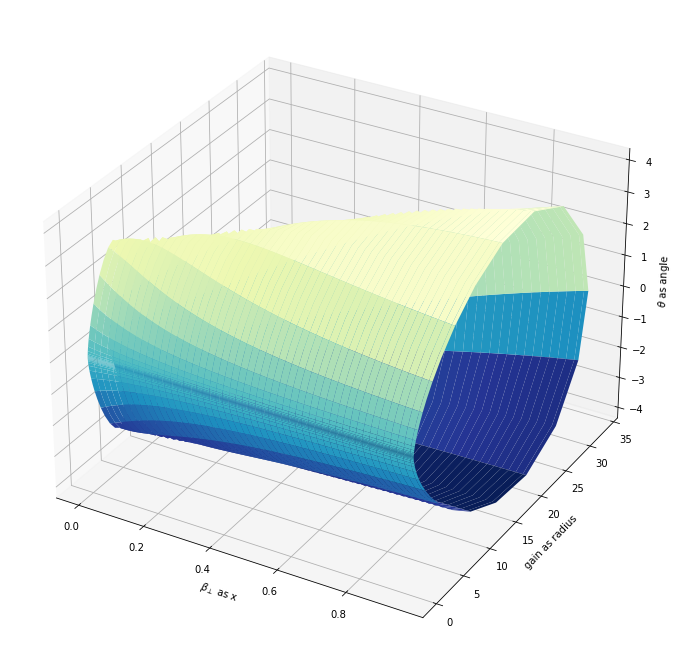

In [37]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
r = np.linspace(1.5, 5, 100)
p = np.linspace(0, 2*np.pi, 100)
ratio, P = np.meshgrid(r, p)
bperp = 0.9/np.sqrt(ratio**2 + 1)
bll = bperp*ratio
R = G(bll, bperp, P)
X = B
Y, Z = R*np.cos(P), R*np.sin(P)
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("$\\beta_{\perp}$ as x")
ax.set_ylabel("gain as radius")
ax.set_zlabel("$\\theta$ as angle")
plt.show()

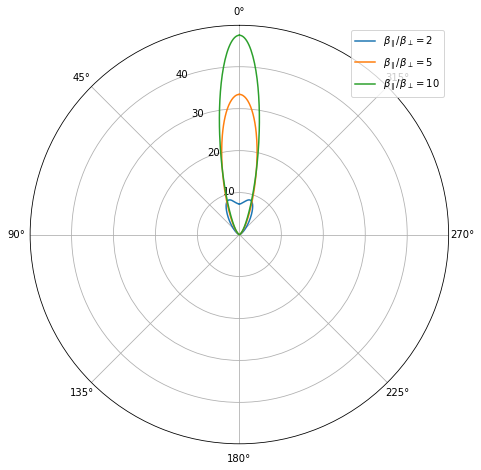

In [38]:
theta = np.linspace(0, 2*np.pi, 1000)
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
for ratio in [2, 5, 10]:
    bperp = 0.9/np.sqrt(ratio**2 + 1)
    bll = bperp*ratio
    ax.plot(theta, G(bll, bperp, theta), label="$\\beta_{\parallel} / \\beta_{\perp} = " + str(ratio) + "$")
plt.legend()
ax.grid(True)
plt.show()